In [ ]:
!pip install yfinance
!pip install scikit-learn

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-2f2a1f1d05b4>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'] = data['Close'].fillna(method='ffill')  # Handle missing values
<ipython-input-2-2f2a1f1d05b4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = data['Close'].fillna(method='ffill')  # Handle missing values
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kw

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17/17 - 3s - 188ms/step - loss: 0.0272 - val_loss: 0.0061
Epoch 2/20
17/17 - 0s - 11ms/step - loss: 0.0025 - val_loss: 9.5831e-04
Epoch 3/20
17/17 - 0s - 17ms/step - loss: 9.5340e-04 - val_loss: 9.9427e-04
Epoch 4/20
17/17 - 0s - 10ms/step - loss: 6.5603e-04 - val_loss: 0.0011
Epoch 5/20
17/17 - 0s - 10ms/step - loss: 6.1277e-04 - val_loss: 0.0012
Epoch 6/20
17/17 - 0s - 16ms/step - loss: 5.9510e-04 - val_loss: 0.0010
Epoch 7/20
17/17 - 0s - 9ms/step - loss: 5.6213e-04 - val_loss: 0.0011
Epoch 8/20
17/17 - 0s - 17ms/step - loss: 5.5433e-04 - val_loss: 9.6840e-04
Epoch 9/20
17/17 - 0s - 18ms/step - loss: 5.2410e-04 - val_loss: 9.3278e-04
Epoch 10/20
17/17 - 0s - 17ms/step - loss: 5.5296e-04 - val_loss: 8.9684e-04
Epoch 11/20
17/17 - 0s - 8ms/step - loss: 5.1362e-04 - val_loss: 9.0042e-04
Epoch 12/20
17/17 - 0s - 8ms/step - loss: 5.0676e-04 - val_loss: 9.0885e-04
Epoch 13/20
17/17 - 0s - 8ms/step - loss: 5.0581e-04 - val_loss: 8.9256e-04
Epoch 14/20
17/17 - 0s - 8ms/step - los

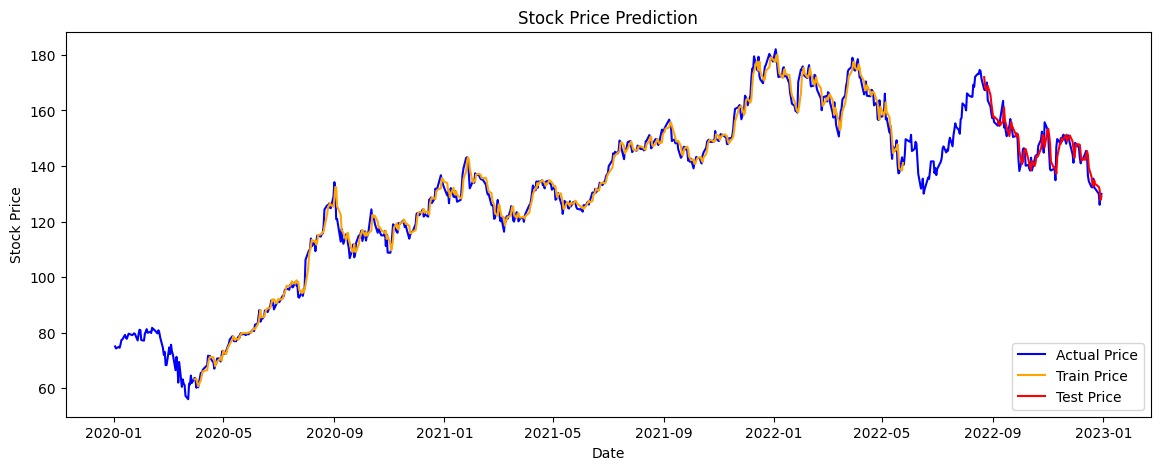

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# load data
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
data = data[['Close']]  # Select 'Close' prices only
data['Close'] = data['Close'].fillna(method='ffill')  # Handle missing values

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

train_size = int(len(scaled_data) * 0.8)
scaled_train_data = scaled_data[:train_size]
scaled_test_data = scaled_data[train_size:]

# Split dataset
def create_dataset(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        Y.append(data[i + seq_length, 0])
    return np.array(X), np.array(Y)

seq_length = 60  # Look-back window size
X_train, y_train = create_dataset(scaled_train_data, seq_length)
X_test, y_test = create_dataset(scaled_test_data, seq_length)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(seq_length, 1), return_sequences=False))
model.add(Dense(1))

model.summary()

# compile model and train
model.compile(optimizer='adam', loss='mse')
losses = model.fit(X_train, y_train,
                   batch_size=32,
                   epochs=20,
                   validation_data=(X_test, y_test),
                   verbose=2)

# evaluate
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")

# Predicting the stock prices
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Prepare for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[seq_length:seq_length + len(train_predict), 0] = train_predict[:, 0]

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[train_size + seq_length:train_size + seq_length + len(test_predict), 0] = test_predict[:, 0]

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Close'], label="Actual Price", color='blue')
plt.plot(data.index, train_predict_plot, label="Train Price", color='orange')
plt.plot(data.index, test_predict_plot, label="Test Price", color='red')
plt.title("Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend(loc="lower right")
plt.show()